#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [3]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [4]:
# from diffeqpy import ode
# from diffeqpy import de

In [5]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [6]:
from sympy import *

In [7]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [8]:
mp = 96 #  (submerged) [kg/m]

In [9]:
node_N=4

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e10*np.array([1, 1, 2]) # [m^4]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[1.e+10, 0.e+00, 0.e+00],
       [0.e+00, 1.e+10, 0.e+00],
       [0.e+00, 0.e+00, 2.e+10]])

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [13]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [14]:
DT=np.diag(diag_DT) # (35) in [2]

In [15]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [16]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [17]:
CT=np.diag(diag_CT)

In [18]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [19]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [20]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [21]:
rng = np.random.default_rng()

In [22]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [23]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [24]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.78556798, -0.10233188,  0.61025498],
       [ 0.32007004,  0.91124224, -0.25921565],
       [-0.52956409,  0.39895585,  0.74859609]])

In [25]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.000984


In [26]:
Ret

array([[[ 0.78556798, -0.10233188,  0.61025498],
        [ 0.32007004,  0.91124224, -0.25921565],
        [-0.52956409,  0.39895585,  0.74859609]],

       [[ 0.89899876, -0.19072777, -0.39423869],
        [ 0.24809746,  0.96360473,  0.09956692],
        [ 0.36090009, -0.18732016,  0.91359853]],

       [[ 0.19493611, -0.0882614 ,  0.97683665],
        [ 0.97030306,  0.16278241, -0.17892419],
        [-0.14321972,  0.98270637,  0.11737248]],

       [[ 0.89048967, -0.32862209, -0.31469933],
        [ 0.24515653,  0.92919067, -0.2765917 ],
        [ 0.38330983,  0.16915146,  0.90799855]]])

In [27]:
Ret.shape

(4, 3, 3)

In [28]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [29]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))
    return ans.T

In [30]:
dx**2

array([0.35672429, 0.60171282, 0.48749381, 0.30488741])

In [31]:
C1(dx,dy,dz,Ret)

array([[ 0.47990361, -0.14269666, -0.01666458,  0.31403632],
       [-0.22228998,  1.14836645,  0.62405721, -0.01240033],
       [-0.09607099,  1.23327797,  0.80144188,  0.07378192]])

In [32]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [33]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.001103


In [34]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [35]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([ 2754.18312588, -1275.72975539,  -551.35465633])

In [36]:
fD(dx,dy,dz,DT,Ret)

array([[ 2754.18312588,  -818.94095277,   -95.63858994,  1802.26508012],
       [-1275.72975539,  6590.51401412,  3581.48551475,   -71.16593229],
       [ -551.35465633,  7077.82410042,  4599.50214074,   423.43692454]])

In [37]:
fD(dx,dy,dz,DT,Ret).T

array([[ 2754.18312588, -1275.72975539,  -551.35465633],
       [ -818.94095277,  6590.51401412,  7077.82410042],
       [  -95.63858994,  3581.48551475,  4599.50214074],
       [ 1802.26508012,   -71.16593229,   423.43692454]])

In [38]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.002127


In [39]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [40]:
I=np.identity(3)

In [41]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000264


In [42]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [43]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [44]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [45]:
DR=np.diag(diag_DR) 

In [46]:
dI= 0.69# Inner diameter of pipe, [m]

In [47]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [51]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [52]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [53]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [54]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [55]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [56]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [57]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [58]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [59]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [60]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000167


In [61]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [62]:
phi(x,y,z,Ret,None)

array([[ -41.61344496,    1.16612716,  118.9720725 ],
       [-177.28060406,   62.82714796,  127.39027576],
       [-146.02860376,  -73.54969102,   -5.80412253],
       [-220.34917128,  -68.4005973 ,  -26.26943939]])

In [63]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [64]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000535


In [65]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [66]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [67]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000411


In [68]:
math.cos(0.5)

0.8775825618903728

In [69]:
φ, θ, ψ = np.array([1e-6 for x in range(node_N)]),np.array([1e-6 for x in range(node_N)]),np.array([1e-6 for x in range(node_N)])

In [70]:
Π(φ,θ,ψ)

array([[[ 1.e+00,  0.e+00,  1.e-06],
        [ 0.e+00,  1.e+00, -1.e-06],
        [-1.e-06,  0.e+00,  1.e+00]],

       [[ 1.e+00,  0.e+00,  1.e-06],
        [ 0.e+00,  1.e+00, -1.e-06],
        [-1.e-06,  0.e+00,  1.e+00]],

       [[ 1.e+00,  0.e+00,  1.e-06],
        [ 0.e+00,  1.e+00, -1.e-06],
        [-1.e-06,  0.e+00,  1.e+00]],

       [[ 1.e+00,  0.e+00,  1.e-06],
        [ 0.e+00,  1.e+00, -1.e-06],
        [-1.e-06,  0.e+00,  1.e+00]]])

In [71]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [72]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.000383


In [73]:
ωe(φ,θ,ψ,None,None)

array([[1.000001e-06, 9.999990e-07, 9.999990e-07],
       [1.000001e-06, 9.999990e-07, 9.999990e-07],
       [1.000001e-06, 9.999990e-07, 9.999990e-07],
       [1.000001e-06, 9.999990e-07, 9.999990e-07]])

In [74]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
#     print('fun',fun)
#     print('K',K)
#     print('ans',np.einsum('ijk,ik->ij',K,fun).T)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T



In [75]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 1.17805824e-04,  6.45630610e-05,  6.77455001e-05,
         4.21311148e-05],
       [-1.60585591e-04, -3.04670833e-04, -1.40224336e-04,
        -1.94079481e-04],
       [ 4.27795320e-05,  2.40107643e-04,  7.24787004e-05,
         1.51948282e-04]])

In [76]:
d_s(ωe,φ,θ,ψ,Ret,ωe(φ,θ,ψ,None,None))

array([[ 1.00004844e-24,  1.00004844e-24,  1.00004844e-24,
         1.00004844e-24],
       [ 4.63625838e-20,  4.63625838e-20,  4.63625838e-20,
         4.63625838e-20],
       [-4.63635840e-20, -4.63635840e-20, -4.63635840e-20,
        -4.63635840e-20]])

In [77]:
# def d_s(f,a,b,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
# #                  +np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
#     ds[ds == 0] = 1
#     fun = f(a,b,c,Ret)
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     return np.insert(ans, -1, 0.8*ans[:,-1], axis=1)

In [78]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [79]:
# d_s(phi,x,y,z,Ret)

In [80]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.000544


In [81]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze())

In [82]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [83]:
# sigma(x,y,z)

In [84]:
ne_(dx,dy,dz,DT,Ret)

array([[-2754.18312588,   818.94095277,    95.63858994, -1802.26508012],
       [ 1275.72975539, -6590.51401412, -3581.48551475,    71.16593229],
       [  423.1901141 , -7205.98864265, -4727.66668297,  -551.60146677]])

In [85]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [86]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001846


In [87]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-4.84714690e+08, -2.65907476e+08,  2.96789626e+08],
       [-7.26517513e+08, -2.30649846e+08, -3.01029287e+08],
       [-7.40501493e+06, -2.57149150e+07,  1.97403606e+06],
       [-7.06099833e+08, -2.11834567e+08, -3.15898866e+08]])

In [88]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000252


In [89]:
Re_b(Ret).shape

(4, 3, 3)

In [90]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans
#     tmp=[1 for i in range(node_N)]
#     tmp[-1]=1e13
#     print(ans)
#     return ans*np.array(tmp).reshape(node_N,1)
#     return np.einsum("ijk,ip->ijk", ans, np.array(tmp).reshape(node_N,1))

In [91]:
Irho_e(Ret)

array([[[6.17117046e+09, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.30362416e+09, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.12079221e+10]],

       [[8.08198771e+09, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.28534077e+09, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.66932456e+10]],

       [[3.80000874e+08, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.64981122e+08, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.75525960e+08]],

       [[7.92971851e+09, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.63395303e+09, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.64892272e+10]]])

In [92]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000183


In [93]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
#                   [0,1,-np.sin(φ)],
#                   [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [94]:
# def Π(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
  
#     return np.apply_along_axis(Π_, 1, xyz)
    

In [95]:
# startTime1 = datetime.now()
# Π(φ,θ,ψ).shape
# print(datetime.now() - startTime1)

In [96]:
# def ωe(φ,θ,ψ, dummy):  # (100) in [2]
#     A=Π(φ,θ,ψ)
#     B=np.vstack([φ,θ,ψ])
#     return np.einsum('ijk,ik->ij',A,B.T)

In [97]:
# startTime1 = datetime.now()
# ωe(φ,θ,ψ,None)
# print(datetime.now() - startTime1)

In [98]:
# ωe(φ,θ,ψ,None)

In [99]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [100]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [101]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega)
#     print(B)
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float64)) 

In [102]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001264


In [103]:
d_me_

array([[ 6.17146937e-14,  3.84977470e-09, -2.59819719e-09],
       [ 8.08237917e-14,  4.30492389e-09, -3.86979348e-09],
       [ 3.80019280e-15,  1.22852095e-10, -6.38718549e-11],
       [ 7.93010260e-14,  4.00292371e-09, -3.82249836e-09]])

In [104]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [105]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [106]:
ne_(dx,dy,dz,DT,Ret)

array([[-2754.18312588,   818.94095277,    95.63858994, -1802.26508012],
       [ 1275.72975539, -6590.51401412, -3581.48551475,    71.16593229],
       [  423.1901141 , -7205.98864265, -4727.66668297,  -551.60146677]])

In [107]:
C=ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [108]:
Re_b(Ret).shape

(4, 3, 3)

In [109]:
ne_(dx,dy,dz,DT, Ret).T

array([[-2754.18312588,  1275.72975539,   423.1901141 ],
       [  818.94095277, -6590.51401412, -7205.98864265],
       [   95.63858994, -3581.48551475, -4727.66668297],
       [-1802.26508012,    71.16593229,  -551.60146677]])

In [110]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([52.78561077, 70.49010452, -4.78765502,  4.41089516]),
 array([  63.36493791,  192.52994848, -130.16751757,   64.41016146]),
 array([ 0.59726401,  0.7757015 ,  0.69820757, -0.5521661 ]),
 numpy.ndarray,
 array([ 0.43929121,  1.03192203, -0.03587659, -0.08719353]))

In [111]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T.astype(np.float64))

array([[ -4790.07514269,   1446.99958808,   2707.46490332],
       [  5653.04143073, -13455.46541337, -12259.27731709],
       [ -4187.76914906,  -3225.79602323,  -8815.81059246],
       [ -3256.96160136,   -151.97601657,  -1731.2428906 ]])

In [112]:
ne_(dx,dy,dz,DT,Ret).T

array([[-2754.18312588,  1275.72975539,   423.1901141 ],
       [  818.94095277, -6590.51401412, -7205.98864265],
       [   95.63858994, -3581.48551475, -4727.66668297],
       [-1802.26508012,    71.16593229,  -551.60146677]])

### Vessel

In [113]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [114]:
V=VesselSemisub()

In [115]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [116]:
tau_force = V.tau(η,dη, ddη)

In [117]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [118]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float64))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float64))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [119]:
V=VesselOtter()

In [120]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [121]:
tau_force = V.tau(η,dη, ddη)

In [122]:
tau_force

array([   0.        ,    0.        , 3925.3734    ,  484.24424147,
       2251.69893789,    0.        ])

In [123]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [124]:
V=VesselSemisub()

In [125]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
kp, kd=1.95e4,1.5e4
# kp,kd=1.95e4, 1.5e4
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [126]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [127]:
Hs = 2.5 # significant wave height in m

In [128]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [129]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [130]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [131]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])
       +wave_coef*np.array([wave_force(Hs,d0,qw),0,0])*np.sin(2*np.pi/Tp*time+1)
      ).T
    Ret=Re_t_([φ,θ,ψ])
    
    ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
    ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return ans

In [132]:
# for i in range(100):
print(tau(η, dη, wave_coef, kp, kd,3))

[5828.76914536 7132.08869406    0.            0.            0.
    0.        ]


### Static solution

In [133]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [134]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [135]:
Fx_0=82945396

In [136]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [137]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [138]:
delta_x=horizontal_length/(node_N-1)

In [139]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [140]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

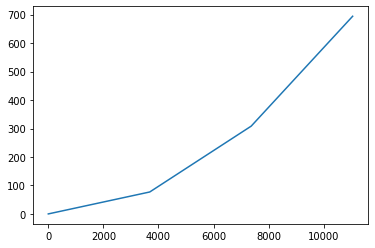

In [141]:
plt.plot(x0, z0)
plt.show()

In [142]:
# rng = np.random.default_rng(seed=29)
rng = np.random.default_rng(seed=21)
q0=np.zeros(12*node_N)

In [143]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [144]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
   
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws*Re_b(Ret),Z).T 
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float64).T
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [145]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [146]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [147]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [148]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [149]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [150]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [151]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [152]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

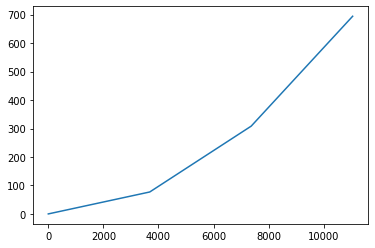

In [153]:
plt.plot(x0_, z0_)
plt.show()

In [154]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([0,1e-6,1e-6,1e-6])
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0,1e-6,1e-6,1e-6])

In [155]:
# q0[10*node_N]=q0[8*node_N]=0

In [156]:
q0

array([0.00000000e+00, 3.68422828e+03, 7.36845656e+03, 1.10526848e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.70680464e+01, 3.08407059e+02, 6.94421895e+02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

### Dynamics

In [157]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
    print(t)
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
# #     x[-1]=x0[-1]+10*np.sin(t)
    x[-1]=x0_[-1]+100*np.sin(t)
#     y[-1]+=5*np.cos(t)
#     z[-1]=z0[-1]+2.5*np.sin(t)
    z[-1]=z0_[-1]+2.5*np.sin(t)

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
#     dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
#     left=V.eq_left(η,dη)

    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_coef, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:

#     hack =1
#     ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, left.astype(np.float32) 
# #                         - tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
#                         , rcond=None)[0]
#     print('ddη', ddη)
 
#     tau_force = V.tau(η,dη,ddη).astype(np.float32)
#     tau_force = tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

#     Z0=np.dot(Re_b(Ret),tau_force[:3])
#     print(x,z)
   
    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
#         + Z0
       )

############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    for i in range(len(RRRR)):
        a,b,c=np.linalg.lstsq(Ws*RRRR[i], Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)
#     print(ddx,ddy, ddz)
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
#     print(d_s(phi,x,y,z,Ret).T)
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= -np.dot(DR,K1).astype(np.float32).T
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ #+C0.squeeze()
    print( +C3)
#     print()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    print(ddφ,ddθ,ddψ)
#     ddx[-1],ddy[-1],ddz[-1],ddφ[-1],ddθ[-1],ddψ[-1]=ddη

    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

#     print(A1111)
    return A1111

In [158]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [159]:
tspan = (0., 50)
# tspan = (0., 10)

In [161]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1, atol=1
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

0.0
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.99822270e-14 -1.47137870e-16  1.47087873e-16]
 [ 4.99822270e-14 -1.47137870e-16  1.47087873e-16]
 [ 4.99822270e-14 -1.47137870e-16  1.47087873e-16]]
[ 0.00000000e+00 -1.84211414e-10 -3.68422852e-10 -5.52634277e-10] [0.         0.00036842 0.00073685 0.00110527] [0.         0.00018421 0.00036842 0.00055263]
1.0042012065268753e-05
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.99822270e-14 -1.47137870e-16  1.47087873e-16]
 [ 4.99822270e-14 -1.47137870e-16  1.47087873e-16]
 [ 4.99822270e-14 -1.47137870e-16  1.47087873e-16]]
[ 0.00000000e+00 -1.84207728e-10 -3.68415507e-10 -5.52623350e-10] [0.         0.00036842 0.00073684 0.00110526] [0.         0.00018421 0.00036842 0.00055263]
0.00020084024130537508
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.99822270e-14 -1.47137870e-16  1.47087873e-16]
 [ 4.99822270e-14 -1.47137870e-16  1.47087873e-16]
 [ 4.99822270e-14 -1.47137870e-16  1.47087873e-16]]
[ 0.00000000e+00 -1

[ 0.00000000e+00 -5.75883372e-08 -1.42140552e-06 -1.45337752e-05] [0.         0.00554959 0.04827434 0.22225627] [0.         0.00097992 0.00554958 0.01856655]
0.1869670488516313
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.54880383e-07 -4.95886435e-13  3.13352163e-12]
 [-2.62905894e-07 -1.91260525e-12  1.70327860e-11]
 [ 4.94532428e-06 -3.02977078e-10  1.30477929e-09]]
[ 0.00000000e+00 -7.13862597e-08 -1.94109111e-06 -2.10180057e-05] [0.         0.00630393 0.05779676 0.27316921] [0.         0.00106358 0.0063039  0.02175491]
0.19299507794763865
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.55413695e-07  1.81395318e-12  1.74908332e-12]
 [ 9.51703457e-06  1.81396249e-11 -4.22542295e-10]
 [ 8.33587503e-05  2.38134948e-10 -1.17205102e-08]]
[ 0.00000000e+00 -8.44847184e-08 -2.42858741e-06 -2.74945704e-05] [0.         0.00693769 0.06568092 0.3191677 ] [0.         0.00114179 0.00693765 0.02436281]
0.19299507794763865
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.1

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.68114705e-07  1.03508541e-12 -5.44786532e-13]
 [-3.82738279e-06  1.38485825e-11  3.15235730e-11]
 [ 1.06951001e-05 -3.35520529e-11 -5.43204278e-10]]
[ 0.00000000e+00 -5.38565244e-08 -1.27620335e-06 -1.27478136e-05] [0.         0.00532357 0.04526287 0.20639241] [0.         0.00095725 0.00532356 0.01757246]
0.18167947321350267
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.76385151e-08  7.40067105e-13 -2.62885421e-12]
 [-8.74126583e-07  9.87459146e-12 -2.08267252e-11]
 [ 2.06480179e-06  4.92103251e-10 -3.01154575e-09]]
[ 0.00000000e+00 -5.46309741e-08 -1.30254945e-06 -1.30737021e-05] [0.         0.00536836 0.04581107 0.209487  ] [0.         0.00096277 0.00536834 0.01775572]
0.18388857641833367
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.40023627e-07 -9.16566807e-13  1.63162195e-12]
 [-1.11134062e-05  4.44933411e-11  8.78840206e-11]
 [ 3.84603009e-05 -1.78208631e-10 -1.82682180e-09]]
[ 0.00000000e+00 -5.86199096e

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.67148812e-07  8.60657453e-14 -2.23668513e-12]
 [ 2.79554487e-06  3.90127505e-11 -2.65805191e-10]
 [ 9.09855518e-05 -2.98277252e-10 -7.07787930e-09]]
[ 0.00000000e+00 -7.67299380e-08 -2.11254097e-06 -2.36984289e-05] [0.         0.00655051 0.0608608  0.29712394] [0.         0.0011047  0.00655048 0.02269707]
0.19233931692434839
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.56653614e-07 -6.63824312e-13  1.87870380e-14]
 [ 1.32663679e-06 -6.36399572e-12 -1.23125832e-11]
 [ 2.05355887e-05  7.84507030e-10 -7.10417799e-09]]
[ 0.00000000e+00 -7.67298534e-08 -2.11253376e-06 -2.36982776e-05] [0.         0.00655051 0.06086064 0.29712252] [0.         0.0011047  0.00655048 0.02269703]
0.19251305709757188
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.16817624e-07 -6.70161025e-13 -4.15270067e-13]
 [ 8.29976932e-06  1.68091237e-11 -3.37402834e-10]
 [ 4.83221654e-06  9.86397510e-10 -6.86836686e-09]]
[ 0.00000000e+00 -7.71550846e

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.86820987e-07 -3.67570173e-13  3.24913604e-12]
 [ 6.99924720e-06 -2.26686888e-11 -1.20565564e-10]
 [ 6.79755439e-05 -6.81134629e-10 -2.53201421e-09]]
[ 0.00000000e+00 -7.95779927e-08 -2.22507221e-06 -2.52603668e-05] [0.         0.006692   0.06274494 0.30848032] [0.         0.00112117 0.00669196 0.02330322]
0.19349749572112432
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.91343461e-07  1.06999143e-12 -4.57878296e-12]
 [-1.21951013e-06 -7.06715301e-11  3.65611289e-10]
 [-1.06305743e-04  5.25656920e-11  1.05843870e-08]]
[ 0.00000000e+00 -7.96133189e-08 -2.22647998e-06 -2.52800213e-05] [0.         0.00669374 0.06276825 0.30862137] [0.         0.00112137 0.00669371 0.02331071]
0.19349749572112432
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.68430506e-07  6.41438066e-13 -3.15234476e-12]
 [-2.10570673e-06 -1.44036248e-11  1.34300604e-10]
 [ 9.30746094e-06  4.01662103e-10 -3.58281663e-09]]
[ 0.00000000e+00 -7.96133189e

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.54204378e-07  1.96857069e-13 -3.26488756e-12]
 [-7.55823761e-06  4.36638771e-11  4.19795906e-11]
 [-6.10227696e-05  3.58470057e-10  3.94091944e-09]]
[ 0.00000000e+00 -7.97739160e-08 -2.23287838e-06 -2.53694024e-05] [0.         0.00670165 0.06287416 0.30926217] [0.         0.00112229 0.00670162 0.0233447 ]
0.19356186344868995
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.59676925e-07  8.12353844e-13  1.11473960e-12]
 [-1.45966176e-06  2.15297370e-12  3.71210095e-11]
 [-2.94621619e-05 -1.21534434e-09  1.09858123e-08]]
[ 0.00000000e+00 -7.97767211e-08 -2.23299004e-06 -2.53709592e-05] [0.         0.00670179 0.06287601 0.30927333] [0.         0.0011223  0.00670176 0.0233453 ]
0.19356736966888163
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.82722466e-07 -1.25771046e-12  1.23156964e-14]
 [-6.40671645e-07 -3.79479871e-11  1.95999240e-10]
 [-7.69206188e-05  6.98770270e-10  3.35376399e-09]]
[ 0.00000000e+00 -7.97907175e

[ 0.00000000e+00 -7.98253037e-08 -2.23492704e-06 -2.53980341e-05] [0.         0.00670419 0.06290805 0.30946723] [0.         0.00112258 0.00670415 0.02335558]
0.19358135760754494
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.32809859e-07  6.92053394e-13 -6.83007435e-12]
 [-9.34486734e-07 -6.90111215e-11  3.49047526e-10]
 [-1.29869683e-05  3.98045894e-10 -1.26581340e-09]]
[ 0.00000000e+00 -7.98262674e-08 -2.23496538e-06 -2.53985670e-05] [0.         0.00670423 0.06290868 0.30947105] [0.         0.00112259 0.0067042  0.02335578]
0.19358135760754494
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.32809404e-07  6.92044864e-13 -6.83004595e-12]
 [-9.34504415e-07 -6.90121194e-11  3.49052708e-10]
 [-1.29872135e-05  3.98013256e-10 -1.26557458e-09]]
[ 0.00000000e+00 -7.98262674e-08 -2.23496538e-06 -2.53985670e-05] [0.         0.00670423 0.06290868 0.30947105] [0.         0.00112259 0.0067042  0.02335578]
0.19357813711810126
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.67948050e-07 -1.05803257e-14  1.30649887e-12]
 [ 4.39218033e-07  3.36751071e-11 -1.69780703e-10]
 [-5.82386834e-05 -2.33645019e-10  7.53186203e-09]]
[ 0.00000000e+00 -7.98240834e-08 -2.23487811e-06 -2.53973484e-05] [0.         0.00670412 0.06290724 0.30946232] [0.         0.00112257 0.00670409 0.02335532]
0.1935805363525555
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.15057863e-07 -1.35182191e-12  3.07939112e-12]
 [ 1.56179852e-06  3.30584792e-11 -2.03147843e-10]
 [-8.19899884e-05  7.80670945e-10  3.34322829e-09]]
[ 0.00000000e+00 -7.98241852e-08 -2.23488211e-06 -2.53974048e-05] [0.         0.00670413 0.0629073  0.30946272] [0.         0.00112257 0.0067041  0.02335534]
0.19358058581316265
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.02871790e-07 -1.33308535e-12  6.95825693e-12]
 [ 6.45193324e-06  3.22832380e-11 -3.57330430e-10]
 [-5.34530561e-05  1.69628962e-10  4.39989069e-09]]
[ 0.00000000e+00 -7.98243037e-

 [-8.58977991e-06  1.16104676e-09 -6.71153733e-09]]
[ 0.00000000e+00 -7.98241030e-08 -2.23487891e-06 -2.53973570e-05] [0.         0.00670413 0.06290725 0.3094624 ] [0.         0.00112257 0.00670409 0.02335532]
0.19358050457542833
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.48398515e-07  2.47791618e-13  1.16193725e-12]
 [ 1.36423185e-06 -7.64426222e-12 -8.68885157e-12]
 [-8.58977991e-06  1.16104676e-09 -6.71153733e-09]]
[ 0.00000000e+00 -7.98241030e-08 -2.23487891e-06 -2.53973570e-05] [0.         0.00670413 0.06290725 0.3094624 ] [0.         0.00112257 0.00670409 0.02335532]
0.19358051074964785
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.24626689e-07 -8.83590646e-13  3.53049531e-12]
 [-2.06386510e-06  7.34034693e-12  3.26646542e-11]
 [ 2.10698376e-05 -2.99976915e-10 -2.09014629e-10]]
[ 0.00000000e+00 -7.98241186e-08 -2.23487965e-06 -2.53973659e-05] [0.         0.00670413 0.06290726 0.30946246] [0.         0.00112257 0.00670409 0.02335533]
0.19358051383675762
[[ 0

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.91905282e-07 -2.40202338e-13 -3.03355743e-12]
 [ 7.49365760e-06 -3.68645210e-11 -7.14101593e-11]
 [-9.68450690e-05 -4.69490125e-11  1.02897311e-08]]
[ 0.00000000e+00 -7.98242261e-08 -2.23488398e-06 -2.53974289e-05] [0.         0.00670413 0.06290733 0.30946291] [0.         0.00112257 0.0067041  0.02335535]
0.19358055629886767
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.03465025e-07  1.28883428e-12  8.14243155e-13]
 [-4.63112379e-06  2.77156729e-11  2.13359175e-11]
 [ 2.45872026e-05 -6.20619145e-10  1.52644590e-09]]
[ 0.00000000e+00 -7.98242404e-08 -2.23488404e-06 -2.53974328e-05] [0.         0.00670413 0.06290734 0.30946293] [0.         0.00112257 0.0067041  0.02335535]
0.19358056303297036
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.32297352e-07 -1.42040219e-13 -2.86790199e-12]
 [-7.30166757e-06  2.53117193e-11  1.18601115e-10]
 [ 6.11678051e-05 -4.91716898e-10 -3.08761978e-09]]
[ 0.00000000e+00 -7.98242500e

 [ 5.64496060e-05  6.83055837e-10 -1.02880434e-08]]
[ 0.00000000e+00 -7.98242495e-08 -2.23488452e-06 -2.53974388e-05] [0.         0.00670413 0.06290734 0.30946297] [0.         0.00112257 0.0067041  0.02335535]
0.19358056086144618
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.95689845e-07  1.04906174e-12  1.45637909e-12]
 [ 3.70726751e-06 -1.36560683e-11 -5.64992974e-11]
 [-7.04586197e-05  6.19478018e-10  3.20932672e-09]]
[ 0.00000000e+00 -7.98242496e-08 -2.23488452e-06 -2.53974404e-05] [0.         0.00670413 0.06290734 0.30946297] [0.         0.00112257 0.0067041  0.02335535]
0.19358056086144618
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.95689845e-07  1.04906174e-12  1.45637909e-12]
 [ 3.70726751e-06 -1.36560683e-11 -5.64992974e-11]
 [-7.04586197e-05  6.19478018e-10  3.20932672e-09]]
[ 0.00000000e+00 -7.98242496e-08 -2.23488452e-06 -2.53974404e-05] [0.         0.00670413 0.06290734 0.30946297] [0.         0.00112257 0.0067041  0.02335535]
0.19358056112043487
[[ 0

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.38133928e-07  6.06656435e-13  2.31300878e-12]
 [ 4.78924224e-06 -3.84909641e-11  2.33549079e-11]
 [-6.05739528e-05  9.82714598e-11  5.60079588e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.19358056151149258
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.48902940e-07  6.89432763e-13  2.15272891e-12]
 [ 4.58679911e-06 -3.38442255e-11  8.41376884e-12]
 [-6.24234255e-05  1.95791932e-10  5.15333951e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.1935805615265498
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.47819199e-07  6.81102584e-13  2.16885863e-12]
 [ 4.60717195e-06 -3.43118498e-11  9.91737053e-12]
 [-6.22373037e-05  1.85977959e-10  5.19836926e-09]]
[ 0.00000000e+00 -7.98242498e-

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.35717658e-07  5.88083681e-13  2.34897124e-12]
 [-9.11240500e-06  6.68741347e-11 -1.50388335e-11]
 [-6.01589820e-05  7.63905384e-11  5.70119288e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.19358056169593915
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.35627449e-07  5.87390292e-13  2.35031386e-12]
 [-9.11070920e-06  6.68352112e-11 -1.49136804e-11]
 [-6.01434899e-05  7.55736546e-11  5.70494100e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.1935805617022057
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.35176418e-07  5.83923411e-13  2.35702677e-12]
 [-9.10223035e-06  6.66405934e-11 -1.42879048e-11]
 [-6.00660291e-05  7.14892509e-11  5.72368157e-09]]
[ 0.00000000e+00 -7.98242498e-

 [-5.98876734e-05  6.20847693e-11  5.76683248e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.1935805617168596
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.34121709e-07  5.75816352e-13  2.37272445e-12]
 [-9.08240322e-06  6.61854952e-11 -1.28245804e-11]
 [-5.98848928e-05  6.19381522e-11  5.76750519e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.1935805617168596
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.34121709e-07  5.75816352e-13  2.37272445e-12]
 [-9.08240322e-06  6.61854952e-11 -1.28245804e-11]
 [-5.98848928e-05  6.19381522e-11  5.76750519e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.1935805617172645
[[ 0.00

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33851735e-07  5.73741233e-13  2.37674249e-12]
 [-9.07732818e-06  6.60690060e-11 -1.24500198e-11]
 [-5.98385281e-05  5.94934079e-11  5.77872248e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.19358056172063004
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33850329e-07  5.73730426e-13  2.37676342e-12]
 [-9.07730179e-06  6.60683997e-11 -1.24480697e-11]
 [-5.98382869e-05  5.94806852e-11  5.77878088e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.19358056172072763
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33843308e-07  5.73676438e-13  2.37686796e-12]
 [-9.07716975e-06  6.60653689e-11 -1.24383245e-11]
 [-5.98370807e-05  5.94170866e-11  5.77907266e-09]]
[ 0.00000000e+00 -7.98242498e

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33814967e-07  5.73458570e-13  2.37728988e-12]
 [-9.07663682e-06  6.60531383e-11 -1.23990013e-11]
 [-5.98322123e-05  5.91604051e-11  5.78025038e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.19358056172112917
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33814409e-07  5.73454285e-13  2.37729815e-12]
 [-9.07662640e-06  6.60528983e-11 -1.23982276e-11]
 [-5.98321166e-05  5.91553539e-11  5.78027356e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.19358056172112917
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33814409e-07  5.73454285e-13  2.37729815e-12]
 [-9.07662640e-06  6.60528983e-11 -1.23982276e-11]
 [-5.98321166e-05  5.91553539e-11  5.78027356e-09]]
[ 0.00000000e+00 -7.98242498e

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33816919e-07  5.73473548e-13  2.37726087e-12]
 [-9.07667355e-06  6.60539808e-11 -1.24017081e-11]
 [-5.98325473e-05  5.91780706e-11  5.78016932e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.1935805617210949
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33816877e-07  5.73473223e-13  2.37726151e-12]
 [-9.07667276e-06  6.60539623e-11 -1.24016487e-11]
 [-5.98325402e-05  5.91776868e-11  5.78017107e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.19358056172109778
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33816668e-07  5.73471620e-13  2.37726462e-12]
 [-9.07666885e-06  6.60538732e-11 -1.24013622e-11]
 [-5.98325046e-05  5.91758113e-11  5.78017968e-09]]
[ 0.00000000e+00 -7.98242498e-

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33816229e-07  5.73468258e-13  2.37727111e-12]
 [-9.07666065e-06  6.60536842e-11 -1.24007545e-11]
 [-5.98324293e-05  5.91718430e-11  5.78019791e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.193580561721104
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33816226e-07  5.73468209e-13  2.37727123e-12]
 [-9.07666050e-06  6.60536815e-11 -1.24007469e-11]
 [-5.98324283e-05  5.91717799e-11  5.78019820e-09]]
[ 0.00000000e+00 -7.98242498e-08 -2.23488472e-06 -2.53974411e-05] [0.         0.00670413 0.06290734 0.30946298] [0.         0.00112257 0.0067041  0.02335535]
0.1935805617211041
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.33816216e-07  5.73468159e-13  2.37727131e-12]
 [-9.07666034e-06  6.60536780e-11 -1.24007356e-11]
 [-5.98324267e-05  5.91717041e-11  5.78019856e-09]]
[ 0.00000000e+00 -7.98242498e-08

In [162]:
fin=us

In [163]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [164]:
fin

  message: 'Required step size is less than spacing between numbers.'
     nfev: 536
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.        , 0.0010042 , 0.01104621, 0.04379888, 0.08604137,
       0.13874282, 0.16337632, 0.18035401, 0.18477222, 0.18919042,
       0.19147062, 0.19233932, 0.19320802, 0.19337201, 0.1934975 ,
       0.19353814, 0.19355856, 0.19356957, 0.19357457, 0.19357796,
       0.19357883, 0.1935797 , 0.19358014, 0.19358032, 0.19358047,
       0.1935805 , 0.19358054, 0.19358054, 0.19358055, 0.19358056,
       0.19358056, 0.19358056, 0.19358056, 0.19358056, 0.19358056,
       0.19358056, 0.19358056, 0.19358056, 0.19358056, 0.19358056,
       0.19358056, 0.19358056, 0.19358056, 0.19358056, 0.19358056,
       0.19358056, 0.19358056, 0.19358056, 0.19358056, 0.19358056,
       0.19358056, 0.19358056, 0.19358056, 0.19358056, 0.19358056])
 t_events: None
        y: array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
     

In [165]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.view_init(-30,-30)
ax.view_init(0,-90)
# ax.view_init(-90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
# t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()